### Import packages

In [ ]:
!pip install brian2
!pip install ipympl
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have num

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import brian2 as b2
from brian2 import *
from brian2.monitors.spikemonitor import SpikeMonitor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sn
import math
import random
from collections import Counter
import os
import h5py
# import ipdb # ipdb.set_trace() ### breakpoint
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
#%matplotlib inline
b2.core.preferences.prefs.codegen.target = "numpy"

b2.defaultclock.dt = 0.1 * b2.ms

Mounted at /content/drive


### Parameters

In [ ]:
ni = 16*16
n_classes = 10
nn = 180
n_train = 3000 # max 5420 # full 7291
n_test = 300 # max 1470 # full 2007

min_spike_time = 1 # ms
max_spike_time = 8 # ms

tau_const = 3.5 # 0.7    3.5
g_const = 3.1 / ni # 0.2   3.1 / ni

k_reduce_coef = 0.999

scale_min = 0.85
scale_max = 1.0
learning_rate = 0.25 #25 # 0.4

repeat = 10
train_period = 30 * b2.ms
time_relax = 60 * b2.ms

experiment_number = 1
use_init_generated_params = False
file_path_init_delays = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/init_delays_{nn}_{experiment_number}.npy'
file_path_scale = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/scale_values_{nn}_{experiment_number}.npy'
use_best_final_delays = False
file_path_final_delays = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/final_delays_{nn}_{experiment_number}.npy'

new_data_loading = False
file_path_train_images = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/train_images_{n_train}.npy'
file_path_train_labels = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/train_labels_{n_train}.npy'
file_path_test_images = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/test_images_{n_test}.npy'
file_path_test_labels = f'drive/My Drive/Colab Notebooks/synaptic_delays_learning_rule/all_usps_synapses_delays/test_labels_{n_test}.npy'

### Functions

In [ ]:
def Data_Encoding(data):
    data_spike_time = np.empty(shape = [0, ni])
    for data_i in data:
        data_new = np.clip(- (max_spike_time - min_spike_time) * data_i + max_spike_time , min_spike_time, max_spike_time)
        data_spike_time = np.vstack([data_spike_time, data_new])
    return data_spike_time

def plot_trained_neurons(current_k):
    plt.figure(figsize = (8, 4))
    plt.plot(np.arange(0, len(current_k)), np.sum(np.heaviside(0.8*learning_rate - np.array(current_k), 0), 1))
    plt.grid()
    plt.xlabel("picture")
    plt.ylabel("number of trained neurons")

def show_plots_v(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    # plot the evolution of membrane potential
    plt.figure(figsize = (8, 4))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[n]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[n]/b2.mV , label='$v_T$')
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        # for t in e_event_mon.event_trains()[n]:
        #     plt.axvline(t/b2.ms, ls='--', c='C3', lw=1) # red == suppress_event
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={n}")

def show_plots_gn(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    # plot the evolution of g_n
    plt.figure(figsize = (8, 4))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[n] , label='$g_n$')
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={n}")

def plot_v_g_n(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    plt.figure(figsize = (8, 4))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[ind]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[ind]/b2.mV , label='$v_T$')
        for t in e_spike_mon.spike_trains()[ind]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={ind}")
    # for ind in ind_input:
    #     plt.figure(figsize = (8, 2))
    #     plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[ind] , label='$g_n$')
    #     for t in e_spike_mon.spike_trains()[ind]:
    #         plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
    #     plt.legend()
    #     plt.xlabel("$t$, ms")
    #     plt.ylabel(f"n={ind}")

def plot_steps_myelin(current_myelin, ind_input, step_range):
    for m in step_range:
        plt.figure(figsize = (8, 2))
        for ind in range(len(ind_input)):
            plt.subplot(1,len(ind_input),ind+1)
            plt.imshow(current_myelin[m][ind_input[ind]].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
            plt.title(f"n={ind_input[ind]} myelin")
            plt.colorbar()

def test_func(snn, times_sample, ind):
    test_mon = SpikeMonitor(snn.group_n)
    snn.net.add(test_mon)
    snn.input_group.set_spikes(list(range(ni)), times_sample * b2.ms + ind*(train_period + time_relax))
    snn.net.run(train_period)
    snn.input_group.set_spikes(list(range(ni)), [3000000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax)
    snn.net.remove(test_mon)
    return test_mon.count

def evaluate(snn, spike_times):
    features = []
    n_samples = len(spike_times)
    for ind in range(n_samples):
        mon_count = test_func(snn, spike_times[ind], ind)
        features.append(np.array(mon_count, dtype=int8))
        if ind % 10 == 0: print(f'Sample done: {ind} / {n_samples}')
    return features

def CreateClasses(snn, train_times, labels, plot = None):
    if plot:
        e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
        spike_mon = SpikeMonitor(snn.group_n)
        snn.net.add(e_state_mon, spike_mon)
    spike_num = np.zeros([n_classes, nn])
    classes_dic = {}
    n_samples = len(train_times)
    for i in range(n_samples):
        spike_num[labels[i], :] += np.asarray(test_func(snn, train_times[i], i))
        if i % 10 == 0: print(f'Sample done: {i} / {n_samples}')
    for j in range(nn):
        if np.sum(spike_num[:, j]) > 0.0:
            classes_dic[j] = str(np.argmax(spike_num[:, j]))
        else: classes_dic[j] = "None"
    print(classes_dic)
    if plot:
        plot_v_g_n(e_state_mon, spike_mon)
        snn.net.remove(e_state_mon, spike_mon)
    return classes_dic

def predict(snn, test_times, classes, plot = None):
    if plot:
        e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
        spike_mon = SpikeMonitor(snn.group_n)
        snn.net.add(e_state_mon, spike_mon)
    pred = []
    n_samples = len(test_times)
    for ind, times_sample in enumerate(test_times):
        spike_num = np.asarray(test_func(snn, times_sample, ind))
        if np.sum(spike_num) > 0.0:
            spiked_neurons, = np.where(spike_num > 0.0)
            spiked_neurons_preds = [classes[spiked_neuron] for spiked_neuron in spiked_neurons]
            counted = Counter(spiked_neurons_preds)
            pred += [max(counted, key=counted.get)]
        else: pred += ["None"]
        if ind % 10 == 0: print(f'Sample done: {ind} / {n_samples}')
    if plot:
        plot_v_g_n(e_state_mon, spike_mon)
        snn.net.remove(e_state_mon, spike_mon)
    return pred

def show_confusion_matrix(pred, labels):
    data = {'y_Actual': labels, 'y_Predicted': pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (10, 8))
    sn.heatmap(confusion_matrix, annot=True)

def show_wrong_pics(pred, labels, images):
    is_wrong_ind = np.array(pred) != np.array(labels)
    for j in range(len(is_wrong_ind)):
        if is_wrong_ind[j]:
            plt.figure(figsize = (4, 4))
            plt.imshow(images[j].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
            plt.xlabel(f"Actual: {labels[j]}, Predicted: {pred[j]}")
            plt.title(f"Wrong recognized pic: {j}")
            plt.colorbar()

def analyse(pred, labels):
    precision = accuracy_score(labels, pred)
    recall = recall_score(labels, pred, average='micro')
    F1_score = f1_score(labels, pred, average='micro')
    return precision, recall, F1_score


### Data loading

Load the data

In [ ]:
if new_data_loading:
    current_dir = os.getcwd()
    with h5py.File('usps.h5', 'r') as hf:
            train = hf.get('train')
            train_X = train.get('data')[:]
            train_Y = train.get('target')[:]
            test = hf.get('test')
            test_X = test.get('data')[:]
            test_Y = test.get('target')[:]

Data balancing

In [ ]:
if new_data_loading:

    n_samples_train = n_train//n_classes
    x_ = []
    y_ = []
    for ind in range(n_classes):
        x_.append(train_X[train_Y==ind][:n_samples_train])
        y_.append(train_Y[train_Y==ind][:n_samples_train])
    y_ = np.array(y_).reshape(-1)
    x_ = np.array(x_).reshape(-1,256)
    data = list(zip(x_,y_))
    random.shuffle(data)
    suffled_data = list(zip(*data))
    train_images = np.array(list(suffled_data[0]))
    train_labels = np.array(list(suffled_data[1]))

    np.save(file_path_train_images, train_images)
    np.save(file_path_train_labels, train_labels)

    n_samples_test = n_test//n_classes
    x_ = []
    y_ = []
    for ind in range(n_classes):
        x_.append(test_X[test_Y==ind][:n_samples_test])
        y_.append(test_Y[test_Y==ind][:n_samples_test])
    y_ = np.array(y_).reshape(-1)
    x_ = np.array(x_).reshape(-1,256)
    data = list(zip(x_,y_))
    random.shuffle(data)
    suffled_data = list(zip(*data))
    test_images = np.array(list(suffled_data[0]))
    test_labels = np.array(list(suffled_data[1]))

    np.save(file_path_test_images, test_images)
    np.save(file_path_test_labels, test_labels)


In [ ]:
with open(file_path_train_images, 'rb') as f:
    train_images = np.load(f)
with open(file_path_train_labels, 'rb') as f:
    train_labels = np.load(f)

with open(file_path_test_images, 'rb') as f:
    test_images = np.load(f)
with open(file_path_test_labels, 'rb') as f:
    test_labels = np.load(f)

Plot neurons number to label hist

In [ ]:
# fntsize = 14
# d = {'1': 6, '6': 31, '0': 29, '3': 42, '4': 33, '8': 39, '5': 34, '2': 41, '7': 22, '9': 15} # 'None': 8

# fig, ax = plt.subplots()
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(fntsize)
# ax.bar(list(d.keys()), d.values())
# ax.grid(axis='y', alpha=0.75)
# ax.set_xlabel('Label', fontsize=fntsize)
# ax.set_ylabel('Number of neurons', fontsize=fntsize)

Plot USPS images

In [ ]:
# fntsize = 18

# plt.figure(figsize = (22, 16))
# for i in range(4):
#     for j in range(6):
#         ax = plt.subplot(4,6,6*i+j+1)
#         for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#             label.set_fontsize(fntsize)
#         plt.imshow(train_images[4*i+j].reshape(16,16), cmap='gray')
#         plt.title(f"image {train_labels[4*i+j]}", fontsize=fntsize)
#         # plt.colorbar()


Encoding

In [ ]:
train_spike_time = Data_Encoding(train_images)
test_spike_time = Data_Encoding(test_images)

# plt.figure(figsize = (12, 11))
# for i in range(4):
#     for j in range(4):
#         plt.subplot(4,4,4*i+j+1)
#         plt.imshow(train_spike_time[4*i+j].reshape(16,16), cmap='gray')
#         plt.title(f"image {train_labels[4*i+j]}")
#         plt.colorbar()


### Model SNN

In [ ]:
class SNN:
    def __init__(self, nn, ni, train_mode, initial_shifts, scale_values, g_const):

        # Input_group neurons
        times = [0]*ni * b2.ms
        self.input_group = b2.SpikeGeneratorGroup(ni, list(range(ni)), times, name = "input_group")

        # Main neurons
        model_n = '''
          dv/dt = (v_rest_n - v + g_n * scale * (E_exc_n - v)) / tau_n: volt
          tau_n : second
          vt_n : volt
          v_rest_n : volt
          v_reset_n : volt
          E_exc_n : volt
          g_n : 1
          k : 1
          scale : 1
          spiked : 1
          reduce_coef : 1
          train_mode_n : 1
          tpre_first : second
          '''
        reset_n = '''
          v = v_reset_n
          spiked = 1
        '''
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset=reset_n,
          refractory=max_spike_time*b2.ms, method='euler', events = {"suppress_event" : "v < v_reset_n"})
        self.group_n.tau_n = tau_const * b2.ms
        self.group_n.vt_n = -52 * b2.mV
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = self.group_n.v_rest_n
        self.group_n.v = self.group_n.v_rest_n
        self.group_n.g_n = 0
        self.group_n.E_exc_n = 0 * b2.mV
        self.group_n.k = learning_rate
        self.group_n.reduce_coef = k_reduce_coef
        self.group_n.scale = scale_values
        self.group_n.spiked = 0

        # EXCISITORY synapses
        model_e = '''
          g = g_amp * exp((tpre + shift + shift_correction - t) / tau_s) * int((t > tpre + shift + shift_correction) and (tpre >= 0 * ms)) : 1
          g_n_post = g : 1 (summed)
          shift : second
          shift_correction : second
          tau_s : second
          g_amp : 1
          tpre : second
          train_mode_e : 1
          '''
        on_pre_e = '''
          tpre = t
          shift += spiked_post * shift_correction
          shift_correction = (1 - spiked_post) * shift_correction
          k_post = spiked_post * train_mode_e * k_post * reduce_coef_post + (1 - spiked_post * train_mode_e) * k_post
          tpre_first = int((tpre_first < 0 * ms) or (t - tpre_first > max_spike_time * ms)) * t + int((tpre_first >= 0 * ms) and (t - tpre_first <= max_spike_time * ms)) * tpre_first
          shift_correction += train_mode_e * k * ((max_spike_time * ms + tpre_first) - (t + shift + shift_correction))
          '''
        on_post_e = {
          "suppress" : '''
            shift_correction = 0 * ms
            spiked_post = 0'''}

        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e,
          on_post=on_post_e, method='euler', on_event={"suppress" : "suppress_event"})
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.tpre = -1 * b2.ms
        self.synapses_e.tpre_first = -1 * b2.ms
        self.synapses_e.tau_s = tau_const / 8 * b2.ms # 0.3 * b2.ms
        self.synapses_e.g_amp = g_const
        self.synapses_e.shift = initial_shifts

        # INHIBITORY synapses
        model_i = '''
          delta_v_post_i : volt
          '''
        on_pre_i = '''
          v_post -= delta_v_post_i
          '''
        self.synapses_i = b2.Synapses(self.group_n, self.group_n, model=model_i, on_pre=on_pre_i, method='euler', delay = 0.1 * b2.ms)
        self.synapses_i.connect(condition='i != j')
        self.synapses_i.delta_v_post_i = 20 * b2.mV

        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e, self.synapses_i)

    def reset_fnc(self):
        self.synapses_e.tpre = -1 * b2.ms

### Training

In [ ]:
if use_init_generated_params:
    with open(file_path_init_delays, 'rb') as f:
        init_delays = np.load(f) * b2.second
    with open(file_path_scale, 'rb') as f:
        scale_values = np.load(f)
else:
    init_delays = np.random.uniform(0 * b2.ms, max_spike_time * b2.ms, ni*nn) * b2.second
    scale_values = np.random.uniform(scale_min, scale_max, nn)

In [ ]:
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'

In [ ]:
snn = SNN(nn, ni, 1, init_delays, scale_values, g_const)

monitor_v =  False
monitor_spikes = False
monitor_delays = False

if monitor_v:
    e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
    e_spike_mon = b2.SpikeMonitor(snn.group_n)
    snn.net.add(e_state_mon, e_spike_mon)
if monitor_spikes:
    train_matr = []
if monitor_delays:
    current_delays = []

current_k = []
actual_number = n_train

import time
start = time.time()

for iter in range(1):
    for pic_number in range(n_train):
        more_time = (iter*n_train + pic_number)*(repeat*train_period + time_relax)

        if monitor_spikes:
            spike_mon = b2.SpikeMonitor(snn.group_n)
            snn.net.add(spike_mon)

        for ind in range(repeat):
            snn.input_group.set_spikes(list(range(ni)), train_spike_time[pic_number] * b2.ms + ind*train_period + more_time)
            snn.net.run(train_period)
            snn.reset_fnc()
            if monitor_delays:
                current_delays.append(np.array((snn.synapses_e.shift/b2.ms)).reshape(ni, nn).transpose())
        current_k.append(np.array(snn.group_n.k))
        snn.group_n.spiked = 0

        snn.input_group.set_spikes(list(range(ni)), [3000000]*ni * b2.ms, 0 * b2.ms)
        snn.net.run(time_relax)

        if monitor_spikes:
            count = np.asarray(spike_mon.count)
            train_matr.append(count)
            snn.net.remove(spike_mon)

        if pic_number % 10 == 0: print(f'Samples done: {pic_number} / {n_train}')

        if np.all(0.8*learning_rate - np.array(snn.group_n.k) > 0):
            actual_number = pic_number + 1
            break

if monitor_v:
    snn.net.remove(e_state_mon, e_spike_mon)

end = time.time() - start
print("Training time: ", end)
print("Actual number of training set: ", actual_number)

initial_delays = (init_delays/b2.um).reshape(ni, nn).transpose()
final_delays = np.array((snn.synapses_e.shift/b2.ms)).reshape(ni, nn).transpose()

np.save(file_path_init_delays, init_delays)
np.save(file_path_scale, scale_values)
np.save(file_path_final_delays, snn.synapses_e.shift)


Samples done: 0 / 3000
Samples done: 10 / 3000
Samples done: 20 / 3000
Samples done: 30 / 3000
Samples done: 40 / 3000
Samples done: 50 / 3000
Samples done: 60 / 3000
Samples done: 70 / 3000
Samples done: 80 / 3000
Samples done: 90 / 3000
Samples done: 100 / 3000
Samples done: 110 / 3000
Samples done: 120 / 3000
Samples done: 130 / 3000
Samples done: 140 / 3000
Samples done: 150 / 3000
Samples done: 160 / 3000
Samples done: 170 / 3000
Samples done: 180 / 3000
Samples done: 190 / 3000
Samples done: 200 / 3000
Samples done: 210 / 3000
Samples done: 220 / 3000
Samples done: 230 / 3000
Samples done: 240 / 3000
Samples done: 250 / 3000
Samples done: 260 / 3000
Samples done: 270 / 3000
Samples done: 280 / 3000
Samples done: 290 / 3000
Samples done: 300 / 3000
Samples done: 310 / 3000
Samples done: 320 / 3000
Samples done: 330 / 3000
Samples done: 340 / 3000
Samples done: 350 / 3000
Samples done: 360 / 3000
Samples done: 370 / 3000
Samples done: 380 / 3000
Samples done: 390 / 3000
Samples don

In [ ]:
end = time.time() - start
print("Training time: ", end)
print("Actual number of training set: ", actual_number)

Training time:  14916.605306148529
Actual number of training set:  1493


In [ ]:
# plt.figure(figsize = (12, 5))
# # plt.hist(train_labels[:actual_number], bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)
# plt.hist(train_labels[:actual_number], bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], color='#0504aa', alpha=0.7, rwidth=0.7)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Label')
# plt.ylabel('Number of samples')

### Visualization of training

In [ ]:
matr = np.vstack([np.arange(nn), np.array(train_matr)])
print(matr[0:1,:])
print(matr[1:11,:])
#print(matr[:30,:])

[[0 1 2 3 4 5 6 7 8 9]]
[[0 0 0 0 0 0 0 0 6 0]
 [0 0 1 0 1 7 1 0 0 0]
 [0 0 0 0 7 0 0 0 0 0]
 [0 0 2 0 0 0 2 2 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 0 1 6 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 1 0 5 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]]


k changing or plotting the trained neurons

In [ ]:
%matplotlib widget

plot_trained_neurons(current_k)

Text(0.5, 0, 'picture')

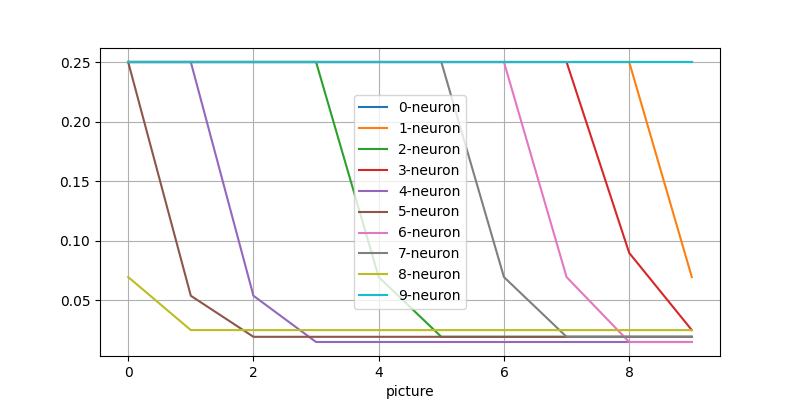

In [ ]:
current_k_arr = np.array(current_k)
plt.figure(figsize = (8, 4))
for i in range(nn):
    plt.plot(np.arange(0, len(current_k)), current_k_arr[:,i], label=f'{i}-neuron')
plt.legend()
plt.grid()
plt.xlabel("picture")

Voltage changing

In [ ]:
%matplotlib widget

ind_input_to_show = [1, 2, 3, 4]
if monitor_v:
    show_plots_v(e_state_mon, e_spike_mon, ind_input_to_show)

ind_input_to_show = [5, 6, 7, 8]
if monitor_v:
    show_plots_v(e_state_mon, e_spike_mon, ind_input_to_show)

ind_input_to_show = [0, 9]
if monitor_v:
    show_plots_v(e_state_mon, e_spike_mon, ind_input_to_show)

g_n changing

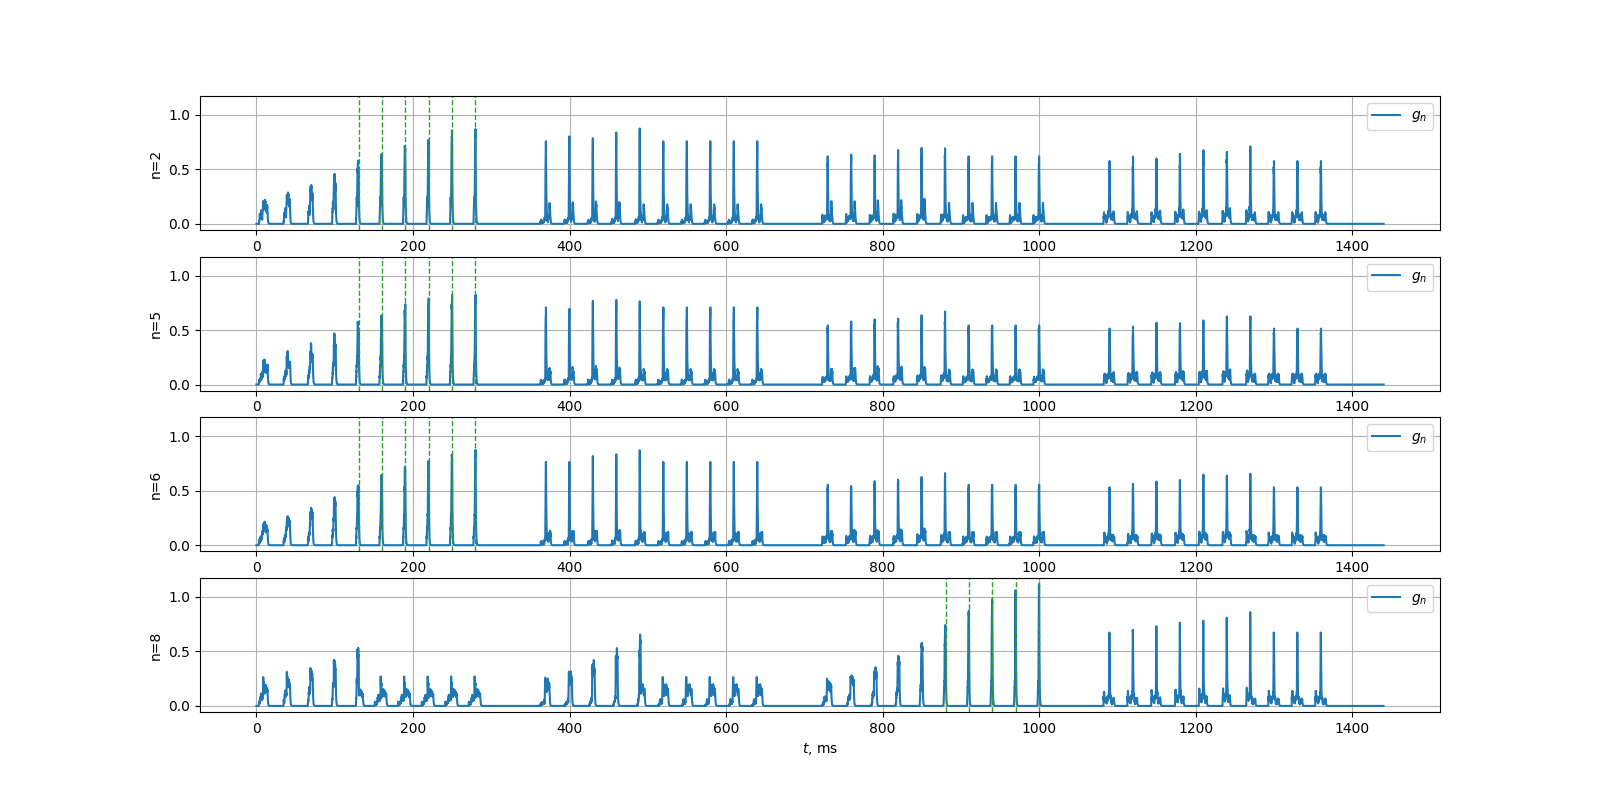

In [ ]:
%matplotlib widget
ind_input_to_show = [2, 5, 6, 8]

if monitor_v:
    show_plots_gn(e_state_mon, e_spike_mon, ind_input_to_show)

Myelin changing

In [ ]:
ind_input = [0, 5, 7]
step_range = np.arange(0,10)

if monitor_delays:
    plot_steps_myelin(current_delays, ind_input, step_range)

Specific images

In [ ]:
# plt.figure(figsize = (6, 2))
# plt.subplot(1,2,1)
# plt.imshow(train_images[0], cmap='gray')
# plt.title("image 0")
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(train_images[5], cmap='gray')
# plt.title("image 1")
# plt.colorbar()

# plt.figure(figsize = (6, 2))
# plt.subplot(1,2,1)
# plt.imshow(train_images[1], cmap='gray')
# plt.title("image 0")
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(train_images[5], cmap='gray')
# plt.title("image 1")
# plt.colorbar()

Final myelin

In [ ]:
# %matplotlib widget

# plt.figure(figsize = (12, 2))
# plt.subplot(1,2,1)
# plt.imshow(train_0[0], cmap='gray')
# plt.title("image 0")
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(train_1[0], cmap='gray')
# plt.title("image 1")
# plt.colorbar()

def plot_final_delays(final_delays, num):
    for i in range(0,num):
        plt.figure(figsize = (3, 2))
        plt.imshow(final_delays[i].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
        plt.title(f"n={i} final delays")
        plt.colorbar()

    # plt.figure(figsize = (3, 2))
    # plt.imshow((final_myelin[0].reshape(round(np.sqrt(ni)), round(np.sqrt(ni)))-final_myelin[6].reshape(round(np.sqrt(ni)), round(np.sqrt(ni)))), cmap='gray')
    # plt.title(f"n={i} final myelin")
    # plt.colorbar()

plot_final_delays(final_delays, nn)


### Results

Classification

In [ ]:
if use_best_final_delays:
    with open(file_path_final_delays, 'rb') as f:
        delay_value = np.load(f) * b2.second
    with open(file_path_scale, 'rb') as f:
        scale_values = np.load(f)
else:
    delay_value = snn.synapses_e.shift


g_const_clf= 3.5 / ni
snn = SNN(nn, ni, 0, delay_value, scale_values, g_const_clf)

classes = CreateClasses(snn, train_spike_time[:actual_number], train_labels[:actual_number], plot = False)

Sample done: 0 / 1493
Sample done: 10 / 1493
Sample done: 20 / 1493
Sample done: 30 / 1493
Sample done: 40 / 1493
Sample done: 50 / 1493
Sample done: 60 / 1493
Sample done: 70 / 1493
Sample done: 80 / 1493
Sample done: 90 / 1493
Sample done: 100 / 1493
Sample done: 110 / 1493
Sample done: 120 / 1493
Sample done: 130 / 1493
Sample done: 140 / 1493
Sample done: 150 / 1493
Sample done: 160 / 1493
Sample done: 170 / 1493
Sample done: 180 / 1493
Sample done: 190 / 1493
Sample done: 200 / 1493
Sample done: 210 / 1493
Sample done: 220 / 1493
Sample done: 230 / 1493
Sample done: 240 / 1493
Sample done: 250 / 1493
Sample done: 260 / 1493
Sample done: 270 / 1493
Sample done: 280 / 1493
Sample done: 290 / 1493
Sample done: 300 / 1493
Sample done: 310 / 1493
Sample done: 320 / 1493
Sample done: 330 / 1493
Sample done: 340 / 1493
Sample done: 350 / 1493
Sample done: 360 / 1493
Sample done: 370 / 1493
Sample done: 380 / 1493
Sample done: 390 / 1493
Sample done: 400 / 1493
Sample done: 410 / 1493
Sam

In [ ]:
values = classes.values()
counter = Counter(values)

print("Number of neurons, reacting to the corresponding image: ", dict(counter))
# for k, v in classes.items():
#     if v == '1':
#         print(f"The order of neuron reacting to the image {v}: ", k)

Number of neurons, reacting to the corresponding image:  {'9': 16, '6': 18, '2': 23, '5': 18, '0': 33, '7': 10, '8': 17, '3': 21, '4': 19, '1': 5}


In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib widget

# fntsize = 14
# d = {'1': 6, '6': 31, '0': 29, '3': 42, '4': 33, '8': 39, '5': 34, '2': 41, '7': 22, '9': 15} # 'None': 8

# fig, ax = plt.subplots()
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(fntsize)
# ax.bar(list(d.keys()), d.values())
# ax.grid(axis='y', alpha=0.75)
# ax.set_xlabel('Label', fontsize=fntsize)
# ax.set_ylabel('Number of neurons', fontsize=fntsize)

Training accuracy

In [ ]:
g_const_test = 3.7 / ni


if use_best_final_delays:
    with open(file_path_final_delays, 'rb') as f:
        delay_value = np.load(f) * b2.second
    with open(file_path_scale, 'rb') as f:
        scale_values = np.load(f)
else:
    delay_value = snn.synapses_e.shift


snn = SNN(nn, ni, 0, delay_value, scale_values, g_const_test)

pred_train = predict(snn, train_spike_time[:actual_number], classes, plot = False)

Sample done: 0 / 1493
Sample done: 10 / 1493
Sample done: 20 / 1493
Sample done: 30 / 1493
Sample done: 40 / 1493
Sample done: 50 / 1493
Sample done: 60 / 1493
Sample done: 70 / 1493
Sample done: 80 / 1493
Sample done: 90 / 1493
Sample done: 100 / 1493
Sample done: 110 / 1493
Sample done: 120 / 1493
Sample done: 130 / 1493
Sample done: 140 / 1493
Sample done: 150 / 1493
Sample done: 160 / 1493
Sample done: 170 / 1493
Sample done: 180 / 1493
Sample done: 190 / 1493
Sample done: 200 / 1493
Sample done: 210 / 1493
Sample done: 220 / 1493
Sample done: 230 / 1493
Sample done: 240 / 1493
Sample done: 250 / 1493
Sample done: 260 / 1493
Sample done: 270 / 1493
Sample done: 280 / 1493
Sample done: 290 / 1493
Sample done: 300 / 1493
Sample done: 310 / 1493
Sample done: 320 / 1493
Sample done: 330 / 1493
Sample done: 340 / 1493
Sample done: 350 / 1493
Sample done: 360 / 1493
Sample done: 370 / 1493
Sample done: 380 / 1493
Sample done: 390 / 1493
Sample done: 400 / 1493
Sample done: 410 / 1493
Sam

In [ ]:
show_confusion_matrix(pred_train, train_labels[:actual_number])
# show_wrong_pics(pred, train_labels[:actual_number], train_images[:actual_number])

In [ ]:
train_labels_str = [str(label) for label in train_labels]
precision, recall, F1_score = analyse(pred_train, train_labels_str[:actual_number])

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) # 0.64 g=3.5

Testing accuracy

In [ ]:
if use_best_final_delays:
    with open(file_path_final_delays, 'rb') as f:
        delay_value = np.load(f) * b2.second
    with open(file_path_scale, 'rb') as f:
        scale_values = np.load(f)
else:
    delay_value = snn.synapses_e.shift


snn = SNN(nn, ni, 0, delay_value, scale_values, g_const_test)

pred_test = predict(snn, test_spike_time, classes, plot = False)

In [ ]:
show_confusion_matrix(pred_test, test_labels)
# show_wrong_pics(pred, test_labels, test_images)

In [ ]:
test_labels_str = [str(label) for label in test_labels]
precision, recall, F1_score = analyse(pred_test, test_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) # 0.42 g=3.5

### F1 changing depending on neurons number

In [ ]:
nn = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 150, 200, 300, 320, 330, 350]
f1_train = [0.235, 0.51, 0.6838, 0.5625, 0.595, 0.541, 0.6816, 0.6465, 0.6387, 0.68, 0.7420, 0.68, 0.5849, 0.649, 0.7035, 0.6488, 0.6548, 0.6426]
f1_test = [0.15, 0.36, 0.46, 0.36, 0.38, 0.498, 0.5467, 0.5333, 0.5433, 0.5, 0.5967, 0.54, 0.4767, 0.5467, 0.6433, 0.5733, 0.5567, 0.55]

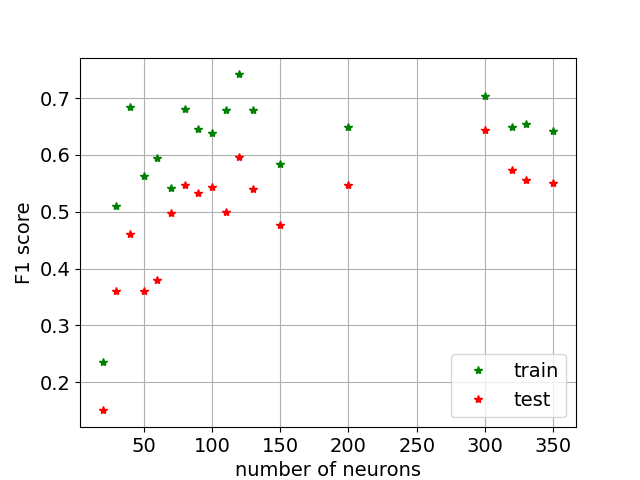

In [ ]:
fntsize = 14

fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fntsize)
# ax.plot(nn, f1_train, 'g', marker='*', label='train')
# ax.plot(nn, f1_test, 'r', marker='*', label='test')
ax.plot(nn, f1_train, 'g*', label='train')
ax.plot(nn, f1_test, 'r*', label='test')
ax.legend(fontsize=fntsize)
ax.set_xlabel("number of neurons", fontsize=fntsize)
ax.set_ylabel("F1 score", fontsize=fntsize)
ax.grid()

### Training myelin rule + Random Forest

In [ ]:
actual_number = 2172

In [ ]:
use_best_final_shift = True

if use_best_final_delays:
    with open(file_path_final_delays, 'rb') as f:
        delay_value = np.load(f) * b2.second
    with open(file_path_scale, 'rb') as f:
        scale_values = np.load(f)
else:
    delay_value = snn.synapses_e.shift


g_const_clf= 3.5 / ni
snn = SNN(nn, ni, 0, delay_value, scale_values, g_const_clf)

train_features = evaluate(snn, train_spike_time[:actual_number])

In [ ]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(train_features, train_labels[:actual_number])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

0.6141804788213628


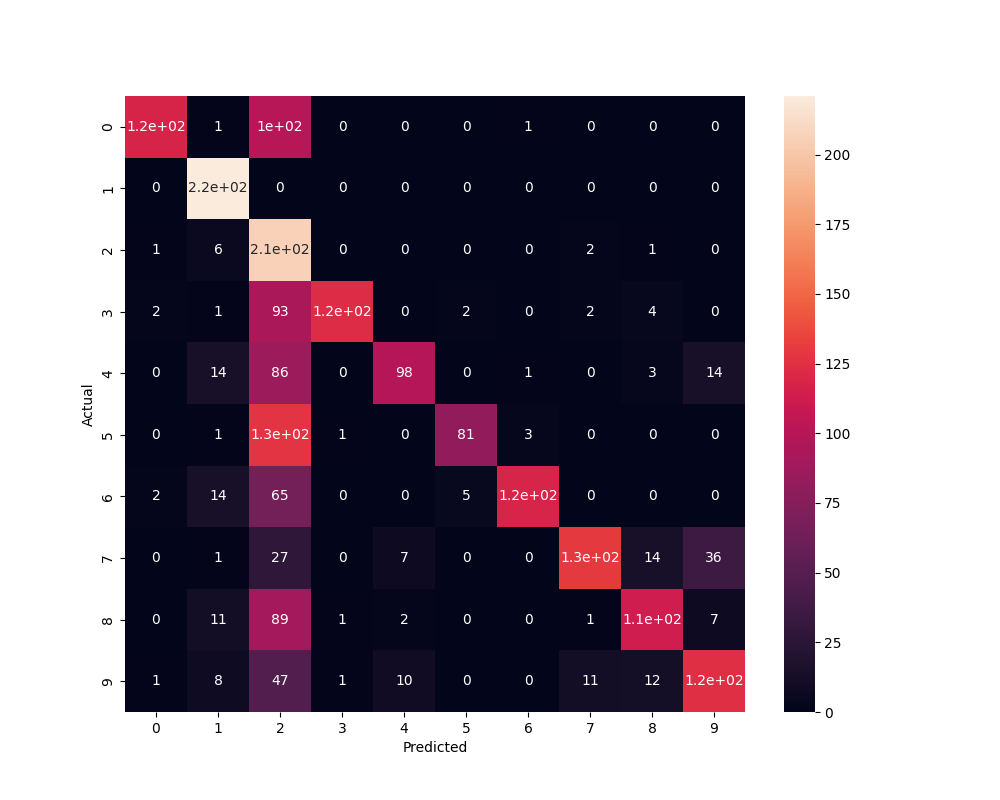

In [ ]:
pred_train = clf.predict(train_features)

print(accuracy_score(pred_train, train_labels[:actual_number]))
show_confusion_matrix(pred_train, train_labels[:actual_number])

In [ ]:
use_best_final_shift = True

if use_best_final_delays:
    with open(file_path_final_delays, 'rb') as f:
        delay_value = np.load(f) * b2.second
    with open(file_path_scale, 'rb') as f:
        scale_values = np.load(f)
else:
    delay_value = snn.synapses_e.shift


g_const_clf= 3.5 / ni
snn = SNN(nn, ni, 0, delay_value, scale_values, g_const_clf)

test_features = evaluate(snn, test_spike_time)

0.5633333333333334


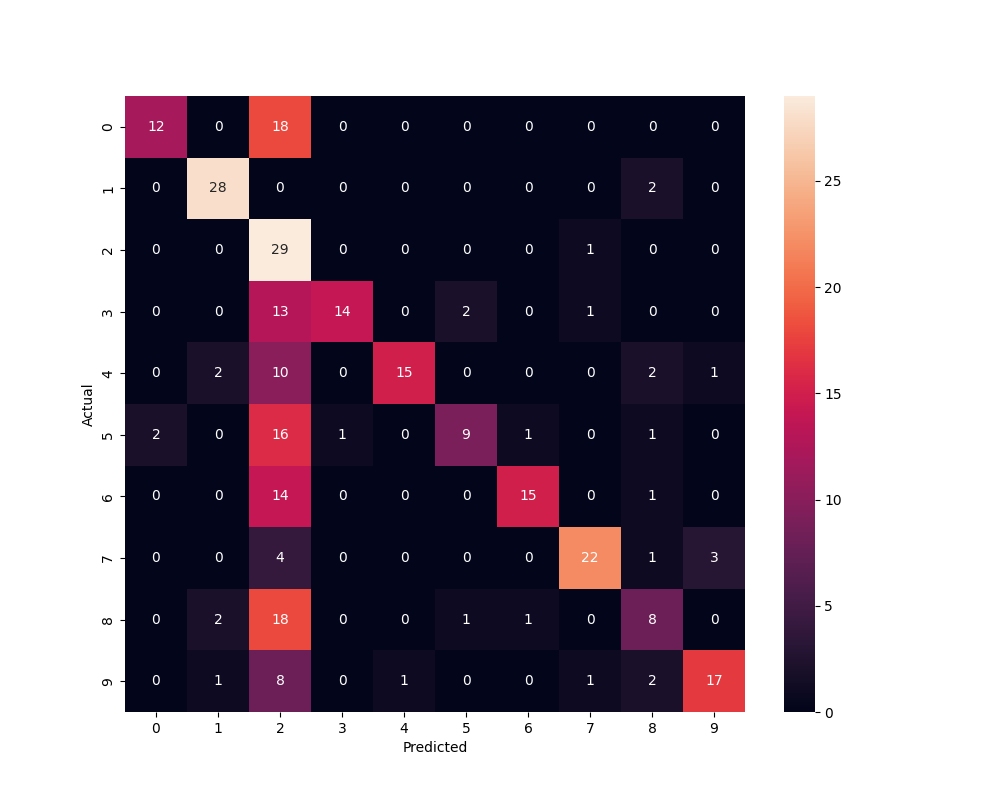

In [ ]:
pred_test = clf.predict(test_features)

print(accuracy_score(pred_test, test_labels))
show_confusion_matrix(pred_test, test_labels)

### Random Forest

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.6944444179534912, 'type': 'set_device_pixel_ratio'}


0.9046961325966851
0.8233333333333334


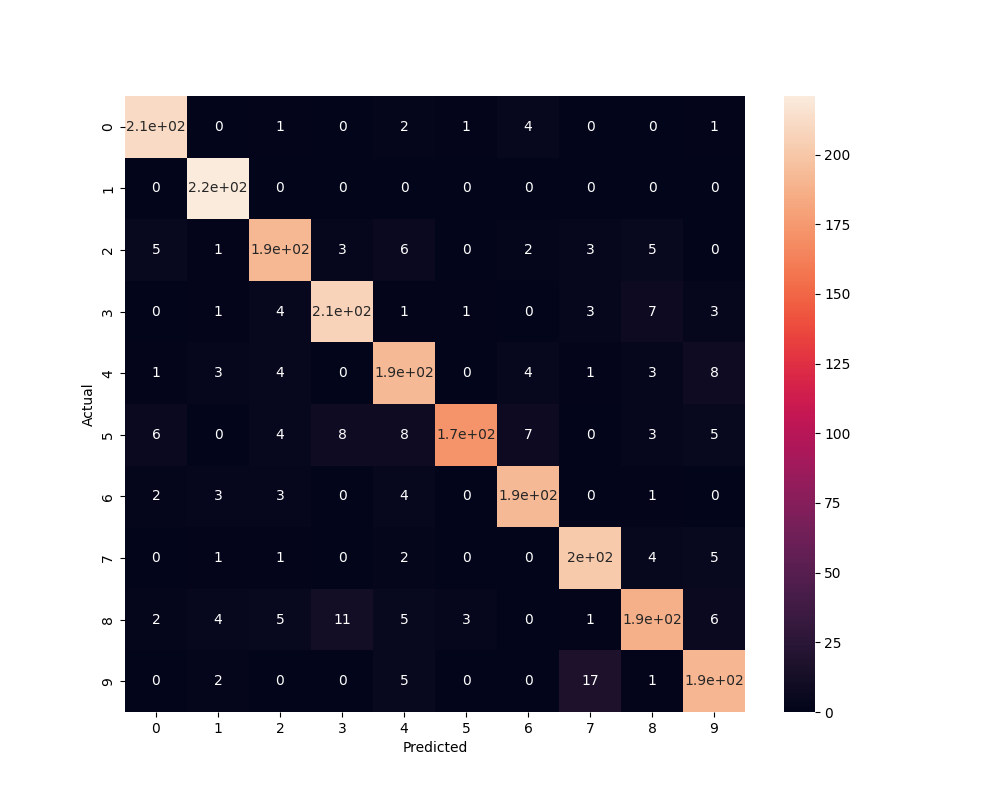

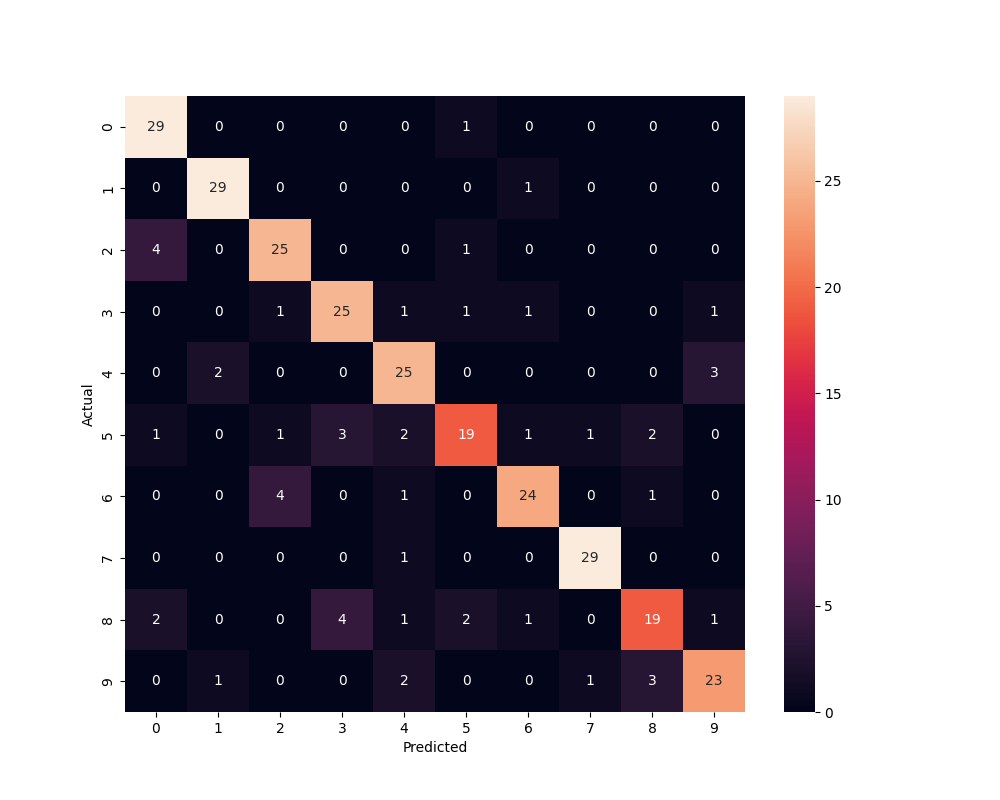

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.6944444179534912, 'type': 'set_device_pixel_ratio'}


In [ ]:
seed(0)


clf = RandomForestClassifier(max_depth=4, random_state=0)
train_features_forest = train_spike_time[:actual_number]
clf.fit(train_features_forest, train_labels[:actual_number])

pred_train_forest = clf.predict(train_features_forest)
print(accuracy_score(pred_train_forest, train_labels[:actual_number]))
show_confusion_matrix(pred_train_forest, train_labels[:actual_number])


test_features_forest = test_spike_time
pred_test_forest = clf.predict(test_features_forest)
print(accuracy_score(pred_test_forest, test_labels))
show_confusion_matrix(pred_test_forest, test_labels)